In [18]:
import torch
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
import torchvision
import time
import itertools
import sklearn
from sklearn.model_selection import KFold

from torch.optim.lr_scheduler import StepLR

torch.manual_seed(42)

In [2]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print("Device being used: ", device)

Device being used:  cuda


In [3]:
scaled_mean= 0.13062754273414612 
scaled_std= 0.30810779333114624

In [4]:
train_dataset =  torchvision.datasets.MNIST('./data/files/', train=True, download=True,  transform=torchvision.transforms.Compose([
                                                                                       torchvision.transforms.ToTensor(),
                                                                                       torchvision.transforms.Normalize((scaled_mean,), (scaled_std,))]))
test_dataset =   torchvision.datasets.MNIST('./data/files/', train=False, download=True,  transform=torchvision.transforms.Compose([
                                                                                       torchvision.transforms.ToTensor(),
                                                                                       torchvision.transforms.Normalize((scaled_mean,), (scaled_std,))]))



Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/files/MNIST/raw/train-images-idx3-ubyte.gz to ./data/files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/files/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/files/MNIST/raw




Extracting ./data/files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=use_gpu)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=use_gpu)

In [6]:
print(f"Size of the train set: {len(train_loader.dataset)}, size of the test set: {len(test_loader.dataset)}")

Size of the train set: 60000, size of the test set: 10000


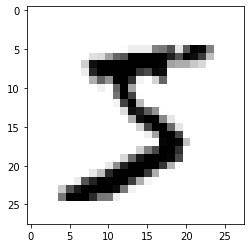

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0].numpy().squeeze(), cmap='gray_r');

In [8]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [9]:
train_dataset[0][1]

5

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 256) 
        self.linear2 = nn.Linear(256, 100) 
        self.final = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x


In [11]:
def reset_weights(m):
    '''
    Reset model weights to avoid weight leakage. Useful during hyperparameter tuning
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [12]:
def train(model, dataloader, criterion, optimizer):
    '''
    Train the given model, using te specified train data (dataloader), loss (criterion) and optimizer
    '''
    for x_batch, y_batch in dataloader:
        
        #Transfer batches to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
import torch.nn.functional as F

def test(model, dataloader):
    '''
    Evaluate the accuracy of the given model, tested on the specified test set (dataloader)
    '''
    correct = 0.0
    total = 0.0

    for x_batch, y_batch in dataloader:
        
        #Transfer batches to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad():
            preds = model(x_batch)           # output of linear
            probs = F.softmax(preds, dim=1) # probability distribution
            preds = probs.argmax(dim=1)      # most probable class (for each sample in the batch)

            correct += (preds == y_batch).sum()
            total += len(preds)
            
    return correct / total # accuracy

# Quick test to see if things are working and to learn how LR-schedulers work

## Constant Learning Rate

In [ ]:

start_time = time.time()

model = Net()
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
    train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer)
    acc = test(model, test_loader)
    
    print(f'Epoch {epoch}: test accuracy {acc:.4}')
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Epoch 0: test accuracy 0.9017
Epoch 1: test accuracy 0.9236
Epoch 2: test accuracy 0.9344
Epoch 3: test accuracy 0.9414
Epoch 4: test accuracy 0.9506
Epoch 5: test accuracy 0.9536
Epoch 6: test accuracy 0.9596
Epoch 7: test accuracy 0.9626
Epoch 8: test accuracy 0.9644
Epoch 9: test accuracy 0.9677
Epoch 10: test accuracy 0.9687
Epoch 11: test accuracy 0.9692
Epoch 12: test accuracy 0.969
Epoch 13: test accuracy 0.9721
Epoch 14: test accuracy 0.9728
Epoch 15: test accuracy 0.9734
Epoch 16: test accuracy 0.9742
Epoch 17: test accuracy 0.9754
Epoch 18: test accuracy 0.9753
Epoch 19: test accuracy 0.9753
--- 397.0 seconds ---


## Increasing Learning Rate

In [ ]:
from torch.optim.lr_scheduler import StepLR

start_time = time.time()

model = Net()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=2)

for epoch in range(20):
    train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer)
    acc = test(model, test_loader)
    
    scheduler.step()
    
    print(f'Epoch {epoch}: test accuracy {acc:.4}')
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Epoch 0: test accuracy 0.9025
Epoch 1: test accuracy 0.9257
Epoch 2: test accuracy 0.9367
Epoch 3: test accuracy 0.944
Epoch 4: test accuracy 0.9506
Epoch 5: test accuracy 0.9556
Epoch 6: test accuracy 0.9628
Epoch 7: test accuracy 0.9665
Epoch 8: test accuracy 0.9717
Epoch 9: test accuracy 0.9716
Epoch 10: test accuracy 0.9717
Epoch 11: test accuracy 0.9752
Epoch 12: test accuracy 0.9772
Epoch 13: test accuracy 0.9721
Epoch 14: test accuracy 0.9789
Epoch 15: test accuracy 0.9779
Epoch 16: test accuracy 0.9674
Epoch 17: test accuracy 0.9712
Epoch 18: test accuracy 0.9788
Epoch 19: test accuracy 0.9797
--- 381.2 seconds ---


## Decaying Learning Rate

In [ ]:
start_time = time.time()

model = Net()
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=5, gamma=1/2)

for epoch in range(20):
    train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer)
    acc = test(model, test_loader)
    
    scheduler.step()
    
    print(f'Epoch {epoch}: test accuracy {acc:.4}')
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Epoch 0: test accuracy 0.9596
Epoch 1: test accuracy 0.9746
Epoch 2: test accuracy 0.9768
Epoch 3: test accuracy 0.9751
Epoch 4: test accuracy 0.9792
Epoch 5: test accuracy 0.9819
Epoch 6: test accuracy 0.9821
Epoch 7: test accuracy 0.9828
Epoch 8: test accuracy 0.9818
Epoch 9: test accuracy 0.9837
Epoch 10: test accuracy 0.9831
Epoch 11: test accuracy 0.9832
Epoch 12: test accuracy 0.9827
Epoch 13: test accuracy 0.983
Epoch 14: test accuracy 0.9835
Epoch 15: test accuracy 0.9831
Epoch 16: test accuracy 0.983
Epoch 17: test accuracy 0.9829
Epoch 18: test accuracy 0.9833
Epoch 19: test accuracy 0.9834
--- 408.5 seconds ---


In [ ]:
# Just to check how the scheduler will work
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=2)
for epoch in range(1, 21):
    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))


Epoch-1 lr: 0.01
Epoch-2 lr: 0.01
Epoch-3 lr: 0.01
Epoch-4 lr: 0.01
Epoch-5 lr: 0.02
Epoch-6 lr: 0.02
Epoch-7 lr: 0.02
Epoch-8 lr: 0.02
Epoch-9 lr: 0.02
Epoch-10 lr: 0.04
Epoch-11 lr: 0.04
Epoch-12 lr: 0.04
Epoch-13 lr: 0.04
Epoch-14 lr: 0.04
Epoch-15 lr: 0.08
Epoch-16 lr: 0.08
Epoch-17 lr: 0.08
Epoch-18 lr: 0.08
Epoch-19 lr: 0.08
Epoch-20 lr: 0.16


C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


# k_fold Cross Validation and Hyperparameter Tuning

In [35]:
def train_with_cross_validation(model, parameters):
    '''
    Perform a K-fold training with CV using the specified parameters.
    This is done by splitting the train set into K-different folds, and performing a training and testing step 
    using the compinations of the folds as new training and validation sets.
    
    This whole procedure is done using the specified parameters for number of folds, loss function, number of epochs, batch size, and optimizer.
    '''
    
    #Define the Kfold to be used when splitting the training dataset
    kfold = KFold(n_splits=parameters["folds"], shuffle = True)
    results = {}
    
    #Itereate K number of times, each time changing the indeces of the train/validation sets
    for fold, (train_index, validation_index) in enumerate(kfold.split(train_dataset)):
        
        print(" -Fold Nr: ", fold+1)
        
        # Create the Training and Validation sets, using the assigned indeces
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_index)
        
        #Use the previous datasets to create DataLoaders with the specified batch_size
        train_loader_Kfold = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler, batch_size=parameters["batch_size"], pin_memory=use_gpu)
        validation_loader_Kfold  = torch.utils.data.DataLoader(train_dataset, sampler=validation_subsampler, batch_size=parameters["batch_size"], pin_memory=use_gpu)        
        

        #Reset the model weights for the new iteration
        model.apply(reset_weights)
        
        #Define the criterion, optimizer and scheduler as specified in the parameters
        criterion = parameters["criterion"]()

        optimizer = parameters["optimizer"](model.parameters(), lr=parameters["lr"])   
        
        scheduler = parameters["scheduler"](optimizer, **parameters["scheduler_parameters"])
       

        #Repeat the training step 'epoch'-number of times. Keep track of the accuracy when testing on the current validation set
        prev_val_accuracy = 0
        for epoch in range(parameters["epochs"]):
            
            train(model, train_loader_Kfold, criterion, optimizer)
            
            current_accuracy = 100.0 * (test(model, validation_loader_Kfold))

            print(f"      Epoch: {epoch+1}/{parameters['epochs']}, Validation Score: {current_accuracy:.4}")

            #Early stopping
            if(current_accuracy < prev_val_accuracy):
              break
            prev_val_accuracy = current_accuracy
            
            scheduler.step()

        results[fold] = current_accuracy

    # Print fold results
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    avg_acc = sum/len(results.items())
    print(f'   Average validation score of the {parameters["folds"]} folds : {avg_acc:.4} %')
    print('--------------------------------')
        
    return avg_acc

In [36]:
def grid_search(model, parameters):
    '''
    Perform a grid search on the model using the given parameters, calling K-fold cross validation for each combination. 
    After all the combinations of parameters have been tried, return the parameters that had the best average validation accuracy.
    '''

    start_time = time.time()

    keys, values = zip(*parameters.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_acc = 0.0
    best_settings = {}
    
    for params in tqdm(permutations_dicts):
        print("-CURRENT PARAMETERS : ", params)
        acc = train_with_cross_validation(model, params)
        
        if acc > best_acc:
            best_acc = acc
            best_settings = params
    print(f"Best overall accuracy {best_acc} for these parameters {best_settings}")
    
    print(f"--- Total time: {((time.time() - start_time)/60):.4} minutes ---" )

    return best_settings, best_acc

In [37]:
parameters_SGD_StepLR = {
    "criterion": [torch.nn.CrossEntropyLoss],
    "optimizer": [torch.optim.SGD],
    "scheduler": [StepLR],
    "scheduler_parameters": [{'step_size':5, 'gamma':1/2}, {'step_size':5, 'gamma':2} ],
    "lr": [0.1, 0.01, 0.001],
    "batch_size": [50, 100],
    "folds": [3],
    "epochs": [20]
}

In [38]:
model = Net()
model.to(device)

best_parameters, best_accuracy = grid_search(model, parameters_SGD_StepLR)

best_parameters

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_parameters': {'step_size': 5, 'gamma': 0.5}, 'lr': 0.1, 'batch_size': 50, 'folds': 3, 'epochs': 20}
 -Fold Nr:  1
      Epoch: 1/20, Validation Score: 94.87
      Epoch: 2/20, Validation Score: 96.71
      Epoch: 3/20, Validation Score: 97.04
      Epoch: 4/20, Validation Score: 97.32
      Epoch: 5/20, Validation Score: 96.99
 -Fold Nr:  2
      Epoch: 1/20, Validation Score: 94.23
      Epoch: 2/20, Validation Score: 96.32
      Epoch: 3/20, Validation Score: 97.1
      Epoch: 4/20, Validation Score: 97.18
      Epoch: 5/20, Validation Score: 97.53
      Epoch: 6/20, Validation Score: 97.72
      Epoch: 7/20, Validation Score: 97.86
      Epoch: 8/20, Validation Score: 97.92
      Epoch: 9/20, Validation Score: 97.85
 -Fold Nr:  3
      Epoch: 1/20, Validation Score: 95.1
      Epoch: 2/20

{'batch_size': 100,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 20,
 'folds': 3,
 'lr': 0.1,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.StepLR,
 'scheduler_parameters': {'gamma': 0.5, 'step_size': 5}}

In [39]:
best_accuracy

tensor(97.2000, device='cuda:0')

In [40]:
best_parameters

{'batch_size': 100,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 20,
 'folds': 3,
 'lr': 0.1,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.StepLR,
 'scheduler_parameters': {'gamma': 0.5, 'step_size': 5}}

In [24]:
best_parameters

{'batch_size': 50,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 20,
 'folds': 3,
 'lr': 0.1,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.StepLR,
 'scheduler_parameters': {'gamma': 0.5, 'step_size': 5}}